In [68]:
from Threshold import binarize
from Morphology import erode, dilate
from Contour import keep_largest_contour
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [69]:
image_raw = cv2.imread('eyes/21L1.bmp', 0)

# TODO

- dobrać operacje morfologiczne dla tęczówki
- przetestować na wszystkich osobach chociaż
- ewentualnie zrobić skośne projekcje
- rozwijanie tęczówki
- raport
- ewentualnie wrzucić na streamlita
- ewentualnie zrobić jakoś lepiej wykrywanie promienia tęczówki
- rozpoznawanie na podstawie rozwiniętej tęczówki

# detekcja źrenicy

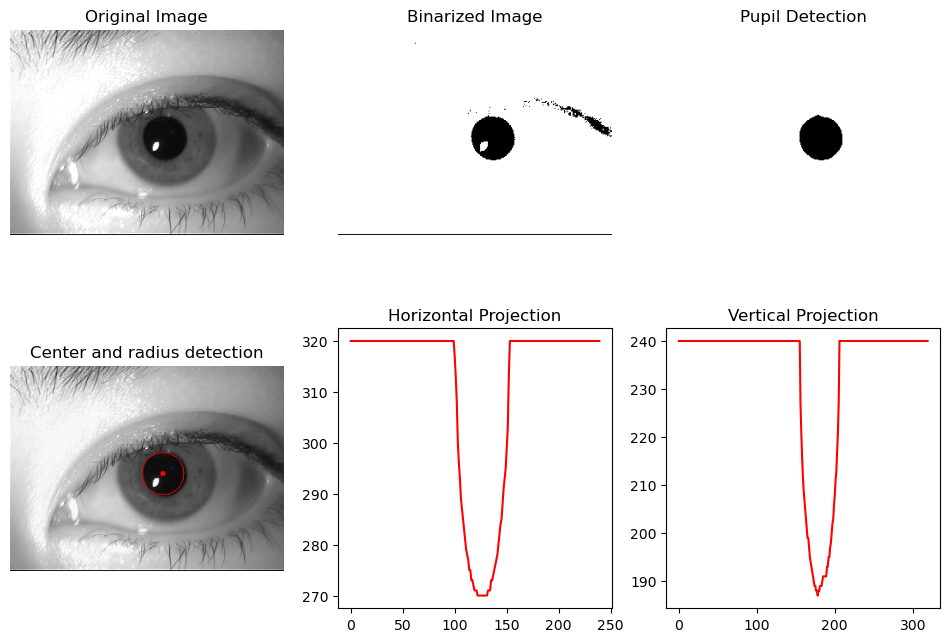

In [70]:
image_bin = binarize(image_raw, threshold=0.22)

# czyszczenie
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
image = cv2.erode(image_bin, kernel, iterations=2)
image = cv2.dilate(image, kernel, iterations=2)
image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=2)
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
image = cv2.medianBlur(image, 5)
image = keep_largest_contour(image)

# projekcja
binary_image = (image > 0).astype(np.uint8)
horizontal_proj = np.sum(binary_image, axis=1)
vertical_proj = np.sum(binary_image, axis=0)

# środek
x = int(np.mean(np.where(vertical_proj == np.min(vertical_proj))[0]))
y = int(np.mean(np.where(horizontal_proj == np.min(horizontal_proj))[0]))

# promień
left_edge = np.min(np.where(vertical_proj < max(vertical_proj)))
right_edge = np.max(np.where(vertical_proj < max(vertical_proj)))
radius_horizontal = (right_edge - left_edge) // 2

top_edge = np.min(np.where(horizontal_proj < max(horizontal_proj)))
bottom_edge = np.max(np.where(horizontal_proj < max(horizontal_proj)))
radius_vertical = (bottom_edge - top_edge) // 2

radius_pupil = (radius_horizontal + radius_vertical) // 2

# zaznaczenie środka i promienia
image_center = cv2.cvtColor(image_raw.copy(), cv2.COLOR_GRAY2BGR)
image_center = cv2.circle(image_center, (x, y), radius_pupil, (255, 0, 0), 1)
image_center = cv2.circle(image_center, (x, y), 0, (255, 0, 0), 5)

# wyświetlenie zdjęć i wykresów
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1); plt.imshow(image_raw, cmap='gray'); plt.title('Original Image'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(image_bin, cmap='gray'); plt.title('Binarized Image'); plt.axis('off') 
plt.subplot(2, 3, 3); plt.imshow(image, cmap='gray'); plt.title('Pupil Detection'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(image_center); plt.title('Center and radius detection'); plt.axis('off')
plt.subplot(2, 3, 5); plt.plot(horizontal_proj, color='red'); plt.title('Horizontal Projection')
plt.subplot(2, 3, 6); plt.plot(vertical_proj, color='red'); plt.title('Vertical Projection')
plt.show()

# detekcja tęczówki

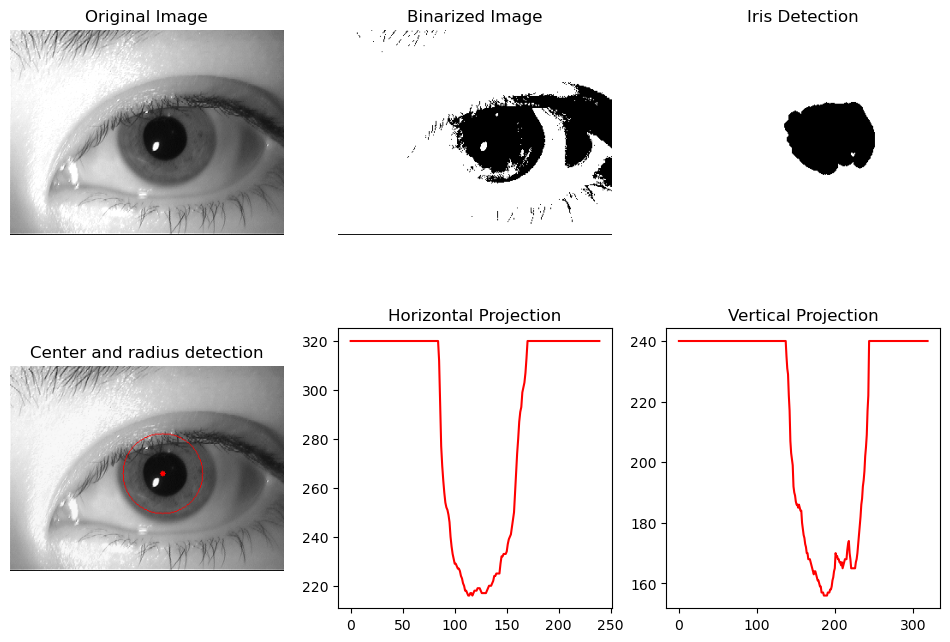

In [71]:
image_bin = binarize(image_raw, threshold=0.55)

# TODO
# czyszczenie
small_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
big_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
image = cv2.dilate(image_bin, big_kernel, iterations=2)
image = cv2.erode(image, small_kernel, iterations=3)
image = keep_largest_contour(image)
image = cv2.erode(image, big_kernel, iterations=2)

# projekcja
binary_image = (image > 0).astype(np.uint8)
horizontal_proj = np.sum(binary_image, axis=1)
vertical_proj = np.sum(binary_image, axis=0)

# promień
left_edge = np.min(np.where(vertical_proj < max(vertical_proj)))
right_edge = np.max(np.where(vertical_proj < max(vertical_proj)))
radius_horizontal = (right_edge - left_edge) // 2

top_edge = np.min(np.where(horizontal_proj < max(horizontal_proj)))
bottom_edge = np.max(np.where(horizontal_proj < max(horizontal_proj)))
radius_vertical = (bottom_edge - top_edge) // 2

radius_iris = (radius_horizontal + radius_vertical) // 2

# zaznaczenie środka i promienia
image_center = cv2.cvtColor(image_raw.copy(), cv2.COLOR_GRAY2BGR)
image_center = cv2.circle(image_center, (x, y), radius_iris, (255, 0, 0), 1)
image_center = cv2.circle(image_center, (x, y), 0, (255, 0, 0), 5)

# wyświetlenie zdjęć i wykresów
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1); plt.imshow(image_raw, cmap='gray'); plt.title('Original Image'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(image_bin, cmap='gray'); plt.title('Binarized Image'); plt.axis('off') 
plt.subplot(2, 3, 3); plt.imshow(image, cmap='gray'); plt.title('Iris Detection'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(image_center); plt.title('Center and radius detection'); plt.axis('off')
plt.subplot(2, 3, 5); plt.plot(horizontal_proj, color='red'); plt.title('Horizontal Projection')
plt.subplot(2, 3, 6); plt.plot(vertical_proj, color='red'); plt.title('Vertical Projection')
plt.show()

# rozwijanie tęczówki